<a href="https://colab.research.google.com/github/sk27110/AutoPriceForecast/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [5]:
df = pd.read_csv('full_cars_data.csv')

In [6]:
df.shape

(206656, 9)

In [7]:
df.head()

,price,title,year,mileage,engine,transmission,body_type,drive_type,color
0,NaN,Mercedes-Benz G-Класс 230 II (W463),1990,197000км,2.3 л / 125 л.с. / Бензин,автомат,внедорожник 3 дв.,полный,серый
1,NaN,Mercedes-Benz S-Класс 560 II (W126) Рестайлинг,1990,2800км,5.6 л / 279 л.с. / Бензин,автомат,седан,задний,коричневый
2,NaN,Toyota Carina V (T170),1990,300000км,1.6 л / 98 л.с. / Бензин,автомат,седан,передний,синий
3,189 700 ₽,Volkswagen Passat B3,1990,325000км,1.8 л / 90 л.с. / Бензин,механика,универсал 5 дв.,передний,красный
4,370 000 ₽,Nissan Terrano I,1990,224000км,2.7 л / 100 л.с. / Дизель,автомат,внедорожник 5 дв.,полный,зелёный


Целевая переменная здесь -- price.

Как мы видим, в колонке price есть пропуски. Давайте удалим все строки, в которых price = NaN

In [8]:
df = df.dropna(subset=['price'])

In [9]:
df['price'].isna().sum()

0

Теперь пропусков в price у нас нет.

Давайте посмотрим, какие единицы измерения есть в столбцах:

In [10]:
print("Различные валюты:", df['price'].apply(lambda x: re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения расстояния:", df['mileage'].apply(lambda x: re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения двигателя:", df['engine'].apply(lambda x: re.sub(r'[\d\s]+', '', x)).unique())

Различные валюты: ['₽']
Различные единицы измерения расстояния: ['км']
Различные единицы измерения двигателя: ['.л/л.с./Бензин' '.л/л.с./Дизель' '.л/л.с./Газ' '.л/л.с./Гибрид'
 'л.с./кВт/Электро']


Как мы видим, с price и mileage все хорошо, а вот с engine придется поработать.

Теперь обработаем параметр engine. Как мы видим, в нем одновременно указан объем, мощьность и вид топлива. Разобъем его на три колонки.

In [11]:
df['engine_capacity'] = np.nan
df['engine_power'] = np.nan
df['fuel_type'] = np.nan

In [12]:
def engine_transform(row):
  try:
    if pd.isna(row['engine']):
      return row
    data = row['engine'].split('/')
    if data[2].strip() == 'Электро':
      data[1] = data[0]
      data[0] = np.nan

    row['engine_capacity'] = data[0]
    row['engine_power'] = data[1]
    row['fuel_type'] = data[2].strip()
    return row
  except:
    print("Ошибка со строкой", row)
    return row

In [13]:
df = df.apply(engine_transform, axis=1)

In [14]:
print(df['engine_capacity'].isna().sum())
print(df['engine_power'].isna().sum())
print(df['fuel_type'].isna().sum())

3606
0
0


Как мы видим, пропусков в новых столбцах нет.

Теперь удалим ненужный столбец engine:

In [15]:
df = df.drop('engine', axis=1)

In [16]:
df.head()

,price,title,year,mileage,transmission,body_type,drive_type,color,engine_capacity,engine_power,fuel_type
3,189 700 ₽,Volkswagen Passat B3,1990,325000км,механика,универсал 5 дв.,передний,красный,1.8 л,90 л.с.,Бензин
4,370 000 ₽,Nissan Terrano I,1990,224000км,автомат,внедорожник 5 дв.,полный,зелёный,2.7 л,100 л.с.,Дизель
5,350 000 ₽,Honda Civic IV,1990,200000км,механика,седан,передний,серебристый,1.6 л,120 л.с.,Бензин
6,360 000 ₽,Volkswagen Passat B3,1990,200000км,механика,универсал 5 дв.,передний,белый,1.8 л,90 л.с.,Бензин
7,99 000 ₽,Toyota Carina V (T170),1990,296000км,автомат,седан,передний,серебристый,1.5 л,94 л.с.,Бензин


В столбец transmission при скрапинге попали данные о дальности хода для электромобилей. Давайте извлечем их оттуда.

In [17]:
import re

df['travel_distance'] = 0


def transmission_transform(row):
  try:
    if pd.isna(row['transmission']):
      return row
    if row['fuel_type'] == 'Электро':
      number = re.findall(r'\d+', row['transmission'])
      if number:
        row['travel_distance'] = int(number[0])
        row['transmission'] = 'none'
        return row
    return row
  except:
    print(row['transmission'])
    return row


df = df.apply(transmission_transform, axis=1)

Посмотрим, какие единицы измерения есть в числовых столбцах, чтобы правильно преобразовать данные:

In [18]:
print("Различные валюты:", df['price'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения расстояния:", df['mileage'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения объема двигателя:", df['engine_capacity'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения мощьности:", df['engine_power'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())

Различные валюты: ['₽']
Различные единицы измерения расстояния: ['км']
Различные единицы измерения объема двигателя: ['.л' nan]
Различные единицы измерения мощьности: ['л.с.']


Преобразуем цену в числовую переменную.

In [19]:
def price_to_int(x):
  if pd.isna(x):
    return np.nan
  return int(x.replace('\xa0', "").replace("₽", ""))


In [20]:
df['price'] = df['price'].apply(price_to_int)

Теперь price -- числовая переменная типа int, единица измерения -- рубли.

Преобразуем mileage в числовой формат.

In [21]:
def mileage_to_int(x):
  if pd.isna(x):
    return np.nan
  return int(x.replace('км', '').replace('\xa0', ""))

In [22]:
df['mileage'] = df['mileage'].apply(mileage_to_int)

Теперь mileage -- числовая переменная, единица измерения -- километры.

In [23]:
def engine_capacity_to_int(x):
  if pd.isna(x):
    return np.nan
  return float(x.replace('л', '').strip())

In [24]:
df['engine_capacity'] = df['engine_capacity'].apply(engine_capacity_to_int)

Теперь engine_capacity -- числовая переменная, единицы измерения -- литры.

Преобразуем engine_power в числовой формат.

In [25]:
def engine_power_to_int(x):
  if pd.isna(x):
    return np.nan
  return float(x.replace('л.с.', '').strip())

In [26]:
df['engine_power'] = df['engine_power'].apply(engine_power_to_int)

Теперь engine_power -- числовая переменная, единицы измерения -- лошадиные силы.

In [27]:
df.dtypes

price                int64
title               object
year                 int64
mileage              int64
transmission        object
body_type           object
drive_type          object
color               object
engine_capacity    float64
engine_power       float64
fuel_type           object
travel_distance      int64
dtype: object

Посмотрим на основные статистики наших данных.

In [28]:
df.describe(include='number')

,price,year,mileage,engine_capacity,engine_power,travel_distance
count,1.991820e+05,199182.000000,199182.000000,195576.000000,199182.000000,199182.000000
mean,2.305377e+06,2010.537955,175138.229825,2.315878,188.135630,9.560417
std,5.746065e+06,8.737646,118841.182301,0.899047,110.511373,72.873968
min,2.500000e+04,1990.000000,1.000000,0.400000,10.000000,0.000000
25%,5.600000e+05,2004.000000,81000.000000,1.600000,116.000000,0.000000
50%,1.200000e+06,2011.000000,170000.000000,2.000000,155.000000,0.000000
75%,2.500000e+06,2018.000000,250000.000000,2.700000,231.000000,0.000000
max,1.000000e+09,2025.000000,1000000.000000,8.300000,1548.000000,1055.000000


Как мы видим, отрицательных значений в данных нет. Экстремально больших значений в данных тоже нет.

In [29]:
df.describe(include='object')

,title,transmission,body_type,drive_type,color,fuel_type
count,199182,199182,199182,199182,199176,199182
unique,8182,5,28,3,16,5
top,Lada (ВАЗ) 2110,автомат,внедорожник 5 дв.,полный,чёрный,Бензин
freq,1130,112515,83983,91939,48846,157290


Давайте посмотрим на уникальные значения в данных:

Посмотрим, есть ли в данных пропуски.

In [30]:
df.isna().sum()

price                 0
title                 0
year                  0
mileage               0
transmission          0
body_type             0
drive_type            0
color                 6
engine_capacity    3606
engine_power          0
fuel_type             0
travel_distance       0
dtype: int64

Посмотрим на процент пропусков в данных:

In [31]:
df.isna().mean()*100

price              0.000000
title              0.000000
year               0.000000
mileage            0.000000
transmission       0.000000
body_type          0.000000
drive_type         0.000000
color              0.003012
engine_capacity    1.810405
engine_power       0.000000
fuel_type          0.000000
travel_distance    0.000000
dtype: float64

Пропущенные значения в engine_capacity -- это данные, в которых тип двигателя -- Электро. У такого двигателя нет объема.

Пропусков в цвете всего 5, скорее всего их не указал продавец или при скрапинге страница не успела прогрузить цвет.

In [32]:
df[df['fuel_type'] == 'Электро'].shape

(3606, 12)

color мы заполним самым популярным значением.


In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df['color'] = imputer.fit_transform(df[['color']]).ravel()

In [34]:
df['color'].isna().sum()

0

Теперь заполним все пропуски в engine_capacity нулями

In [35]:
df['engine_capacity'] = df['engine_capacity'].fillna(0)

In [36]:
df['engine_capacity'].isna().sum()

0

In [37]:
df.isna().sum().sum()

0

Построим boxplot для всех числовых признаков, чтобы посмотреть на распределение данных (на travel_distance посмотрим потом, так там большинство нулей).

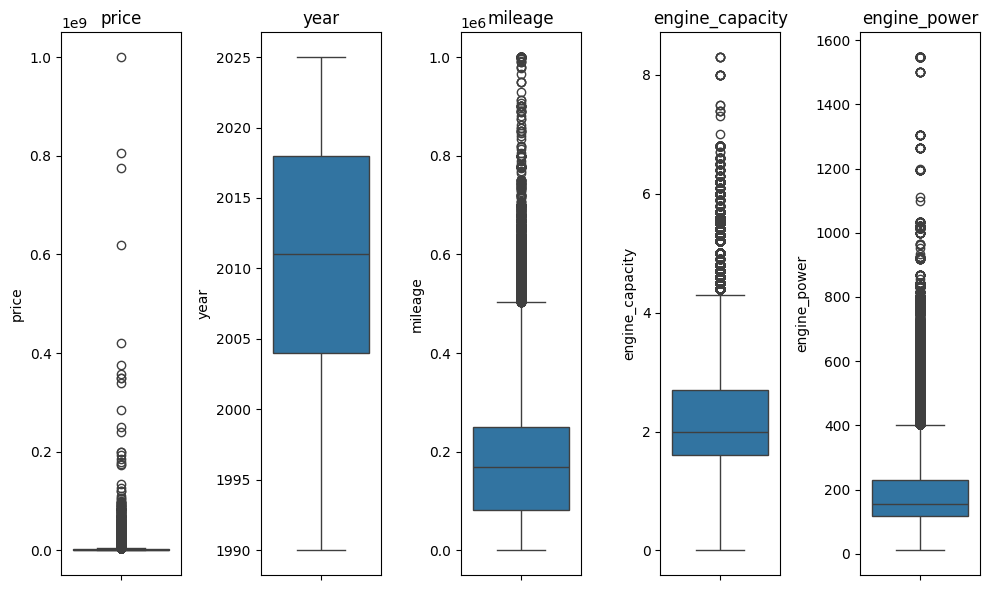

In [38]:
plt.figure(figsize=(10, 6))

cols = ['price', 'year', 'mileage', 'engine_capacity', 'engine_power']

for i, col in enumerate(cols):
    plt.subplot(1, len(cols), i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

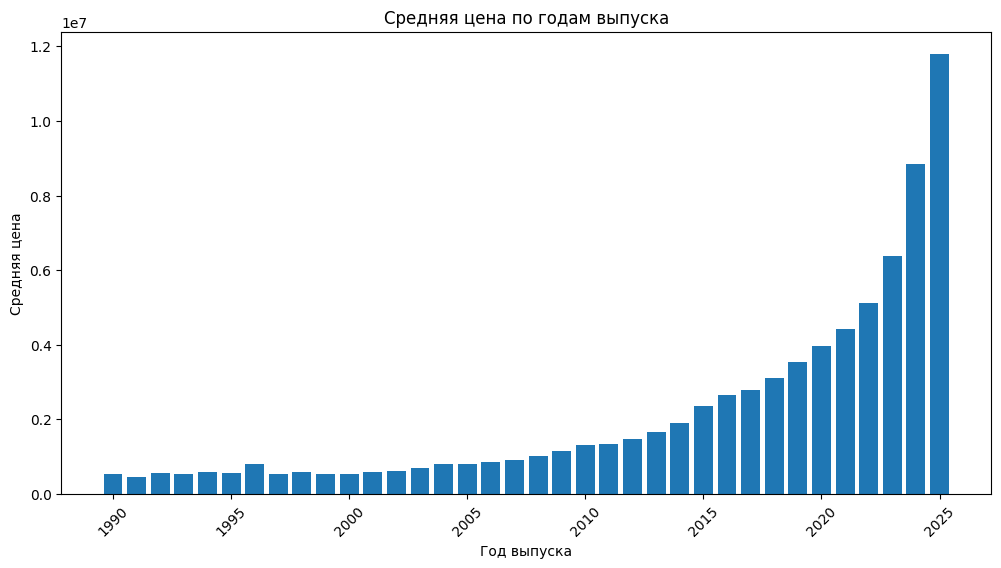

In [39]:
year_price = df.groupby('year')['price'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(year_price['year'], year_price['price'])
plt.title('Средняя цена по годам выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя цена')
plt.xticks(rotation=45)
plt.show()

Получаем совершенно ожидаемое распределение цены в зависимости от года выпуска. Так, как в наших данных учитывается динамика рынка за долгий период, вероятность переобучения и неточных прогнозов в будущем из-за этого мала&

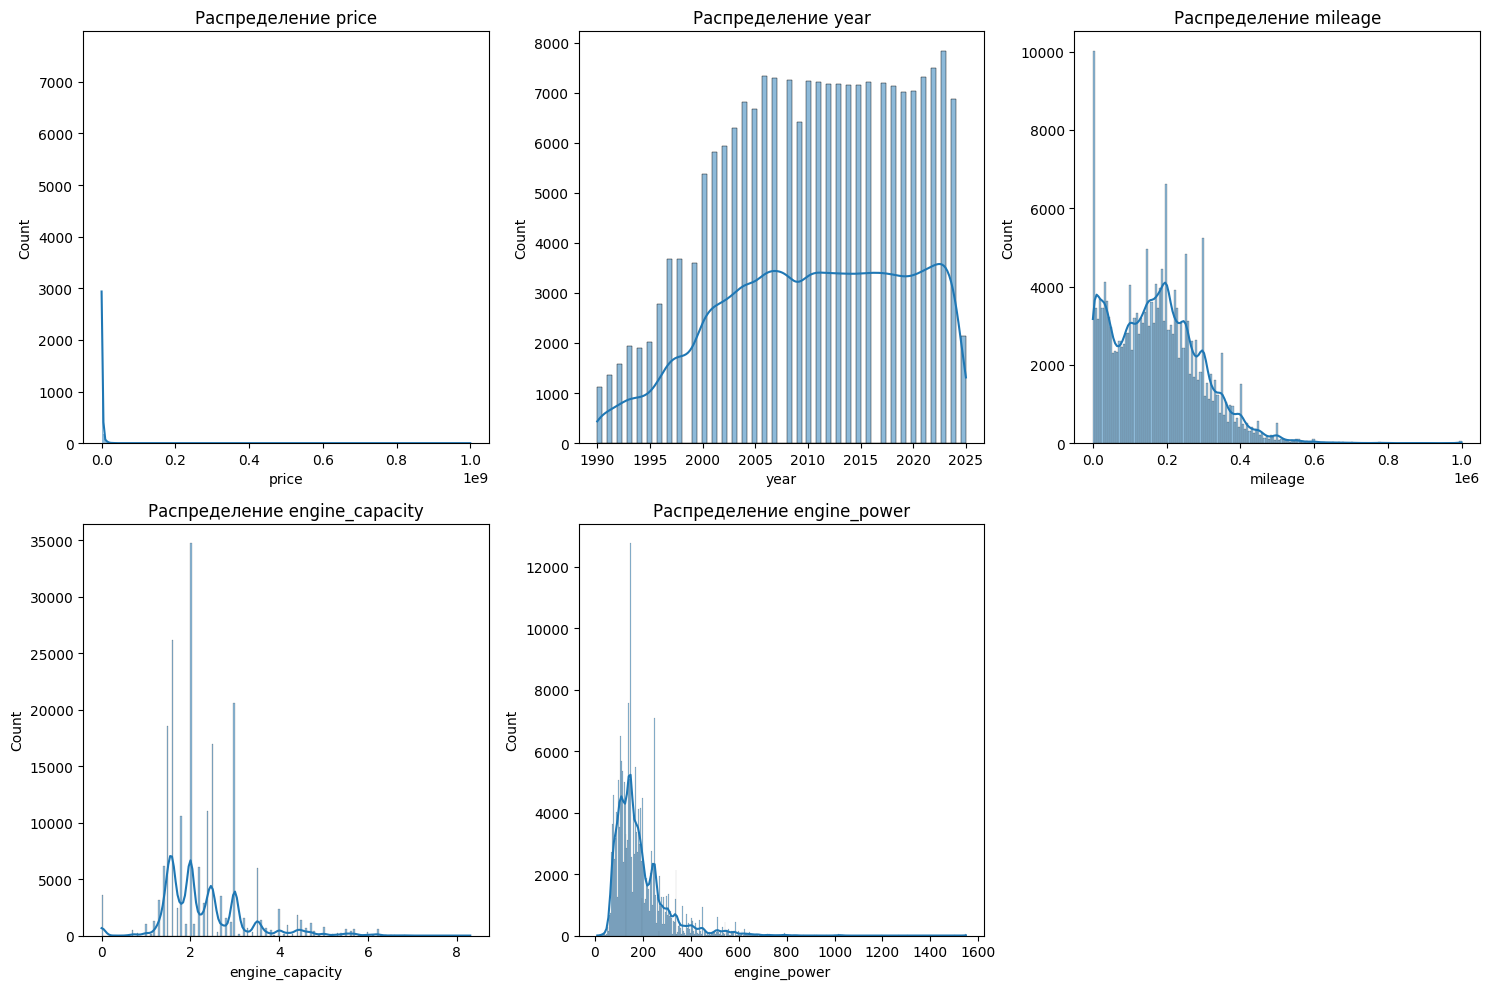

In [40]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

### Посмотрим на распределение числовых признаков в наших данных:
- `price` - подкрепляя данными boxplot выше мы можем заметить, что большинство моделей сконцентрированы в относительно невысоком ценовом диапазоне. Ассиметрия может помешать моделям, в этом случае мы можем прменить преобразование.
- `year` - относительно равномерное с 2020 по 2024 года.
- `mileage` - большинство автомобилей имеет относительно небольшой пробег, а небольшое число — экстремально большой (правостороняя асимметрия). Возможно нужно будет выполнить преобразование.
- `engine_capacity` - распределение также сдвинуто вправо, но в целом меньше «радикальных» выбросов, чем у цены или пробега.
- `engine_power` - аналогично, правосторонняя асимметрия. 

## Проанализируем влияение цвета на целевую переменную

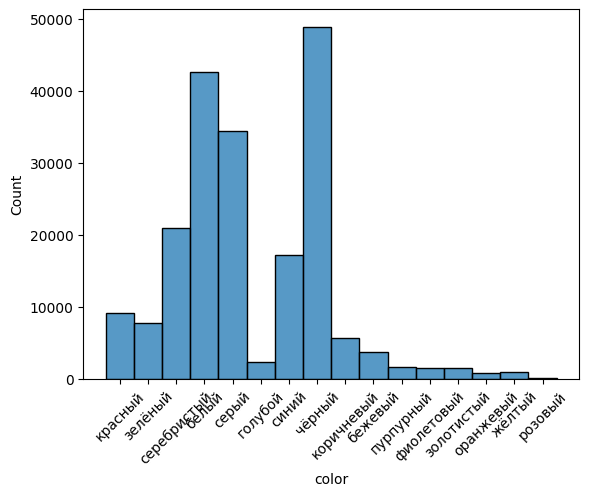

In [72]:
sns.histplot(data=df, x='color')
plt.xticks(rotation=45)
plt.show()

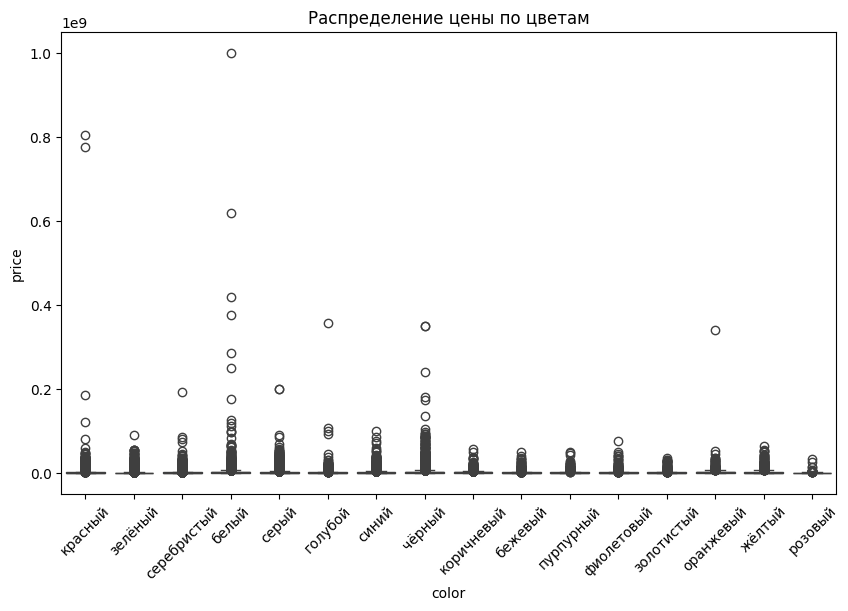

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='color', y='price', data=df)
plt.title('Распределение цены по цветам')
plt.xticks(rotation=45)
plt.show()

In [ ]:
pivot_color = df.pivot_table(
    index='color',
    values='price',
    aggfunc='mean'
)
pivot_color

,price
color,
бежевый,820000.0
белый,1670000.0
голубой,760000.0
жёлтый,1050000.0
зелёный,450000.0
золотистый,800000.0
коричневый,1525000.0
красный,750000.0
оранжевый,1350000.0


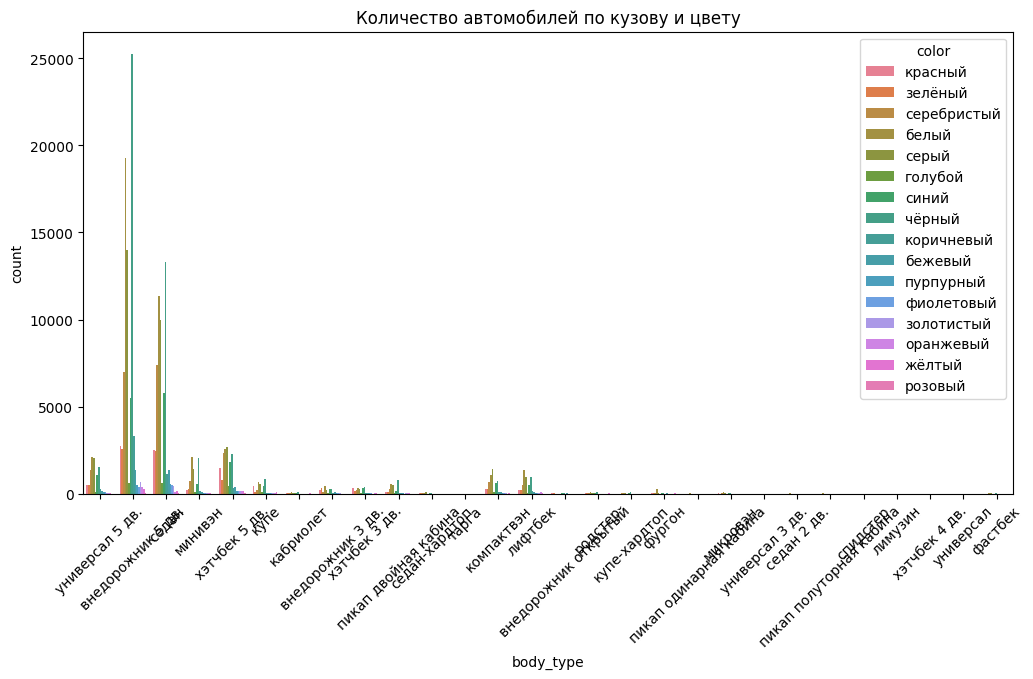

In [ ]:

plt.figure(figsize=(12, 6))
sns.countplot(x='body_type', hue='color', data=df)
plt.title('Количество автомобилей по кузову и цвету')
plt.xticks(rotation=45)
plt.show()

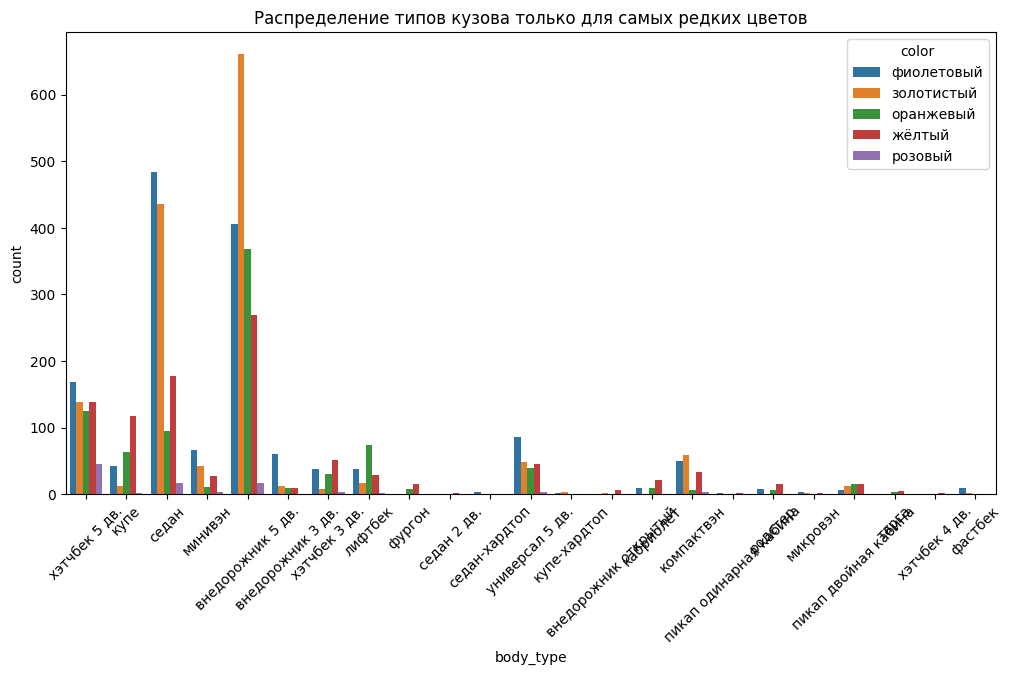

In [ ]:
n_rare = 5

color_counts = df['color'].value_counts(ascending=True)
rare_colors = color_counts.index[:n_rare]  

df_rare = df[df['color'].isin(rare_colors)]

plt.figure(figsize=(12, 6))
sns.countplot(x='body_type', hue='color', data=df_rare)
plt.title('Распределение типов кузова только для самых редких цветов')
plt.xticks(rotation=45)  
plt.show()

In [74]:
ct = pd.crosstab(df['body_type'], df['color'])

ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100
ct_percent = ct_percent.round(2)

threshold = 0

print(ct_percent.where(ct_percent >= threshold))

color                    бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
body_type                                                                       
внедорожник 3 дв.           3.71  21.81     0.91    0.48    14.59        0.58   
внедорожник 5 дв.           1.65  22.95     0.76    0.32     3.04        0.79   
внедорожник открытый        9.35   6.47     6.47    5.04    33.09        1.44   
кабриолет                   0.78  19.96     3.13    4.11     4.11        0.20   
компактвэн                  1.41  19.10     2.21    0.60     4.39        1.08   
купе                        0.36  18.10     2.25    3.24     3.41        0.36   
купе-хардтоп                0.85  19.66     1.71    0.43     2.14        1.28   
лимузин                     0.00  50.00     0.00    0.00     0.00        0.00   
лифтбек                     1.60  26.41     0.93    0.56     4.60        0.33   
микровэн                    2.65  30.68     1.89    0.76     3.03        0.76   
минивэн                     

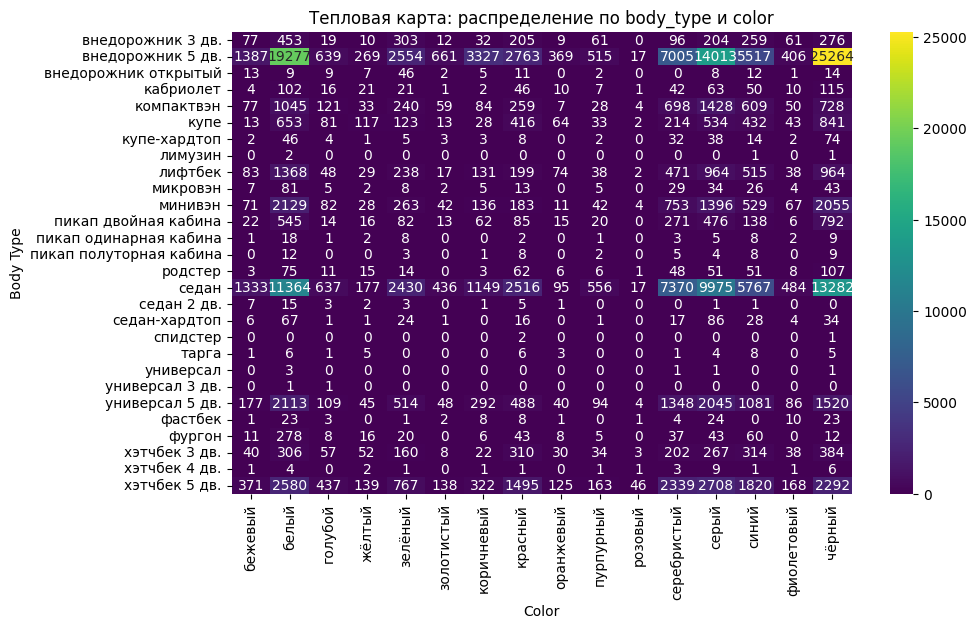

In [73]:
ct = pd.crosstab(df['body_type'], df['color'])

plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='viridis')
plt.title('Тепловая карта: распределение по body_type и color')
plt.xlabel('Color')
plt.ylabel('Body Type')
plt.show()